In [1]:
# 필요한 라이브러리 설치하기
!git clone https://github.com/ndb796/bing_image_downloader

Cloning into 'bing_image_downloader'...
remote: Enumerating objects: 86, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 86 (delta 17), reused 10 (delta 10), pack-reused 64
Unpacking objects: 100% (86/86), 17.48 KiB | 941.00 KiB/s, done.


In [12]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

In [2]:
import os
import shutil
from bing_image_downloader.bing_image_downloader import downloader


directory_list = [
    './custom_dataset/train/',
    './custom_dataset/test/',
]

# 초기 디렉토리 만들기
for directory in directory_list:
    if not os.path.isdir(directory):
        os.makedirs(directory)

# 수집한 이미지를 학습 데이터와 평가 데이터로 구분하는 함수
def dataset_split(query, train_cnt):
    # 학습 및 평가 데이터셋 디렉토리 만들기
    for directory in directory_list:
        if not os.path.isdir(directory + '/' + query):
            os.makedirs(directory + '/' + query)
    # 학습 및 평가 데이터셋 준비하기
    cnt = 0
    for file_name in os.listdir(query):
        if cnt < train_cnt:
            print(f'[Train Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/train/' + query + '/' + file_name)
        else:
            print(f'[Test Dataset] {file_name}')
            shutil.move(query + '/' + file_name, './custom_dataset/test/' + query + '/' + file_name)
        cnt += 1
    shutil.rmtree(query)

In [ ]:
query = '캔 쓰레기'
downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 30)

In [ ]:
query = '플라스틱'
downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 30)

In [ ]:
query = '종이 쓰레기'
downloader.download(query, limit=40,  output_dir='./', adult_filter_off=True, force_replace=False, timeout=60)
dataset_split(query, 30)

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import time


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # device 객체

* 데이터셋을 불러옵니다.

In [7]:
# 데이터셋을 불러올 때 사용할 변형(transformation) 객체 정의
transforms_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(), # 데이터 증진(augmentation)
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # 정규화(normalization)
])

transforms_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './custom_dataset'
train_datasets = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_datasets = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=4, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_datasets, batch_size=4, shuffle=True, num_workers=4)

print('학습 데이터셋 크기:', len(train_datasets))
print('테스트 데이터셋 크기:', len(test_datasets))

class_names = train_datasets.classes
print('클래스:', class_names)

학습 데이터셋 크기: 90
테스트 데이터셋 크기: 30
클래스: ['종이 쓰레기', '캔 쓰레기', '플라스틱']


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


* 학습할 CNN 딥러닝 모델 객체를 초기화합니다.

In [9]:
model = models.resnet34(pretrained=True)
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 218MB/s]


* 학습을 진행합니다.

In [10]:
num_epochs = 50
model.train()
start_time = time.time()

# 전체 반복(epoch) 수 만큼 반복하며
for epoch in range(num_epochs):
    running_loss = 0.
    running_corrects = 0

    # 배치 단위로 학습 데이터 불러오기
    for inputs, labels in train_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델에 입력(forward)하고 결과 계산
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # 역전파를 통해 기울기(gradient) 계산 및 학습 진행
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_datasets)
    epoch_acc = running_corrects / len(train_datasets) * 100.

    # 학습 과정 중에 결과 출력
    print('#{} Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

#0 Loss: 0.9908 Acc: 50.0000% Time: 10.2174s
#1 Loss: 0.8320 Acc: 63.3333% Time: 13.9658s
#2 Loss: 0.3619 Acc: 86.6667% Time: 16.7226s
#3 Loss: 0.4122 Acc: 81.1111% Time: 19.4375s
#4 Loss: 0.3233 Acc: 93.3333% Time: 22.1461s
#5 Loss: 0.0909 Acc: 96.6667% Time: 26.2567s
#6 Loss: 0.2257 Acc: 93.3333% Time: 28.9363s
#7 Loss: 0.2966 Acc: 92.2222% Time: 31.6697s
#8 Loss: 0.3825 Acc: 87.7778% Time: 34.3779s
#9 Loss: 0.3053 Acc: 91.1111% Time: 37.9540s
#10 Loss: 0.1912 Acc: 90.0000% Time: 41.1336s
#11 Loss: 0.2444 Acc: 88.8889% Time: 44.0272s
#12 Loss: 0.4938 Acc: 85.5556% Time: 46.8169s
#13 Loss: 0.5484 Acc: 84.4444% Time: 49.9209s
#14 Loss: 0.4008 Acc: 87.7778% Time: 53.5298s
#15 Loss: 0.2540 Acc: 93.3333% Time: 56.3116s
#16 Loss: 0.2351 Acc: 93.3333% Time: 59.0347s
#17 Loss: 0.1595 Acc: 94.4445% Time: 61.7397s
#18 Loss: 0.1896 Acc: 92.2222% Time: 65.8697s
#19 Loss: 0.2389 Acc: 93.3333% Time: 68.6342s
#20 Loss: 0.1145 Acc: 96.6667% Time: 71.4331s
#21 Loss: 0.0744 Acc: 98.8889% Time: 74.2552

* 학습된 모델을 평가합니다.

[예측 결과: 종이 쓰레기] (실제 정답: 캔 쓰레기)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44208 (\N{HANGUL SYLLABLE GYEOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44284 (\N{HANGUL SYLLABLE GWA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51333 (\N{HANGUL SYLLABLE JONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packag

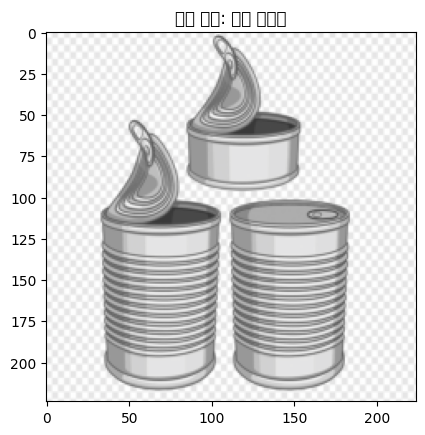

[예측 결과: 종이 쓰레기] (실제 정답: 종이 쓰레기)


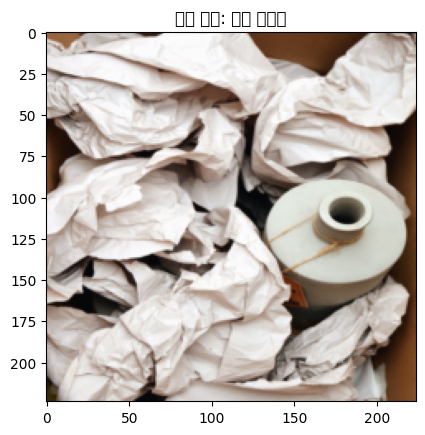

[예측 결과: 캔 쓰레기] (실제 정답: 캔 쓰레기)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 52884 (\N{HANGUL SYLLABLE KAEN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


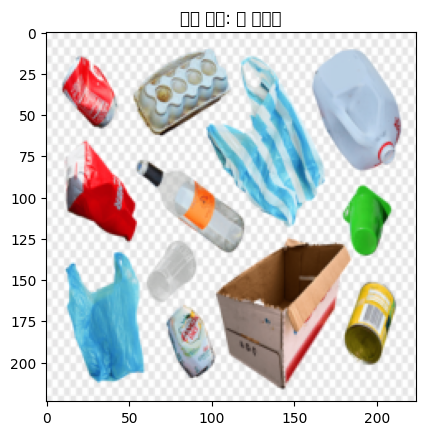

[예측 결과: 캔 쓰레기] (실제 정답: 캔 쓰레기)


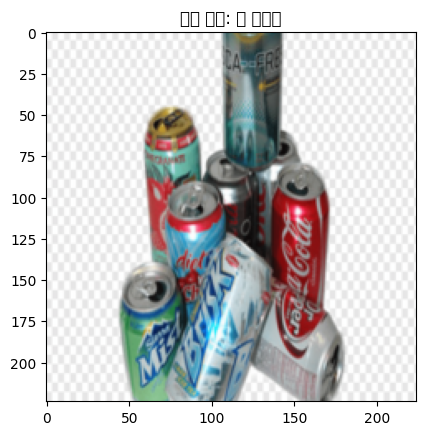

[예측 결과: 캔 쓰레기] (실제 정답: 캔 쓰레기)


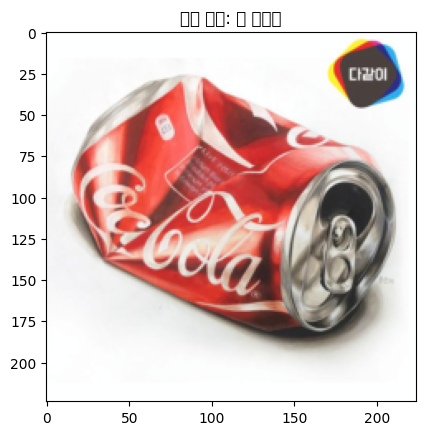

[예측 결과: 플라스틱] (실제 정답: 플라스틱)


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54001 (\N{HANGUL SYLLABLE TIG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


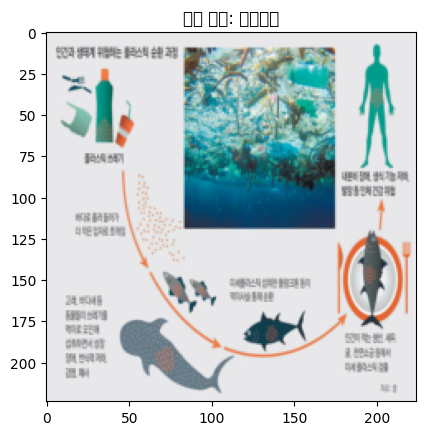

[예측 결과: 종이 쓰레기] (실제 정답: 종이 쓰레기)


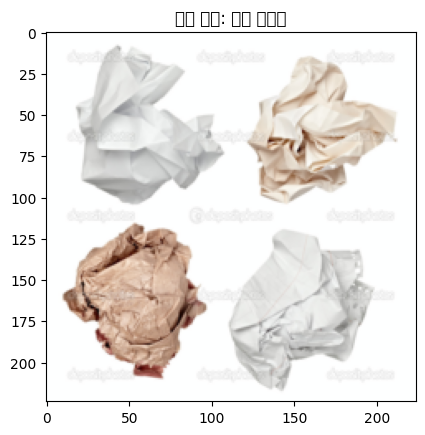

[예측 결과: 플라스틱] (실제 정답: 플라스틱)


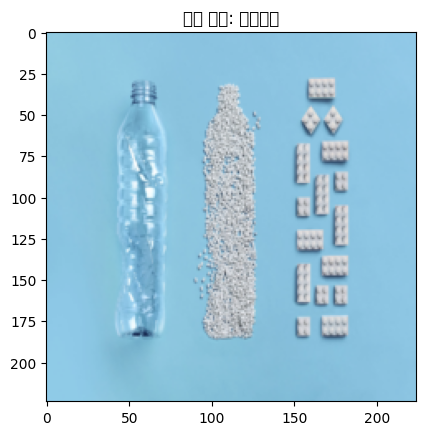

[Test Phase] Loss: 0.5426 Acc: 80.0000% Time: 3.5606s


In [13]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for inputs, labels in test_dataloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # 한 배치의 첫 번째 이미지에 대하여 결과 시각화
        print(f'[예측 결과: {class_names[preds[0]]}] (실제 정답: {class_names[labels.data[0]]})')
        imshow(inputs.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])

    epoch_loss = running_loss / len(test_datasets)
    epoch_acc = running_corrects / len(test_datasets) * 100.
    print('[Test Phase] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch_loss, epoch_acc, time.time() - start_time))

저장하기

In [14]:
torch.save(model.state_dict(), './model.pt')

In [20]:
model = models.resnet34(pretrained=True)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_features = model.fc.in_features
# 전이 학습(transfer learning): 모델의 출력 뉴런 수를 3개로 교체하여 마지막 레이어 다시 학습
model.fc = nn.Linear(num_features, 3) # 2개 class
model = model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [21]:
model.load_state_dict(torch.load('/content/model.pt'))
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [22]:
labels = labels.to(device)

In [25]:
# 테스트용 이미지 다운로드하기
!wget https://img.etnews.com/photonews/2106/1427824_20210625170440_979_0001.jpg -O test_image.jpg

--2023-06-13 08:38:52--  https://img.etnews.com/photonews/2106/1427824_20210625170440_979_0001.jpg
Resolving img.etnews.com (img.etnews.com)... 112.175.235.210
Connecting to img.etnews.com (img.etnews.com)|112.175.235.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119869 (117K) [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>] 117.06K   692KB/s    in 0.2s    

2023-06-13 08:38:53 (692 KB/s) - ‘test_image.jpg’ saved [119869/119869]



플라스틱


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46972 (\N{HANGUL SYLLABLE RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54001 (\N{HANGUL SYLLABLE TIG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


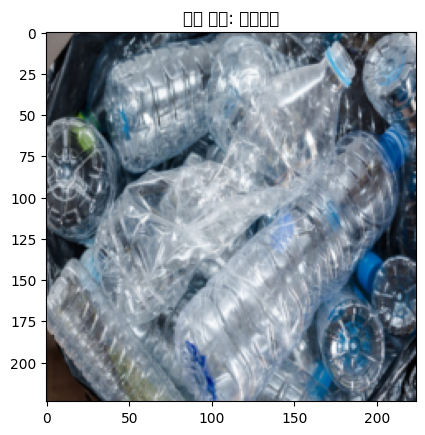

In [26]:
from PIL import Image

running_corrects = 0
image = Image.open('test_image.jpg')
image = transforms_test(image).unsqueeze(0).to(device)

with torch.no_grad():
  outputs = model(image)
  _, preds = torch.max(outputs,1)
  print(class_names[preds[0]])

  # running_corrects += torch.sum(preds == labels.data)
  # print(running_corrects)

  # epoch_acc = running_corrects / 20 * 100
  # print(epoch_acc)

  imshow(image.cpu().data[0], title='예측 결과: ' + class_names[preds[0]])